#  Homework 5 - Berkeley STAT 157

**Your name: XX, SID YY** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
from matplotlib import pyplot as plt
import d2l

mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `sneaker` and `pullover` and class $-1$ being the combination of `sandal` and `shirt` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

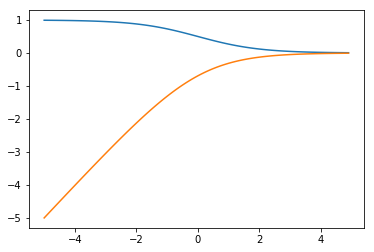

In [2]:
#1
def logisticLoss(f, y):
    return -nd.log(1 + nd.exp(-y * f))
#2
y = nd.ones(1)
f = nd.arange(-5, 5, 0.1)
f.attach_grad()
with autograd.record():
    l = logisticLoss(f, y)
l.backward()

plt.plot(f.asnumpy(), f.grad.asnumpy())
plt.plot(f.asnumpy(), l.asnumpy())
plt.show()


In [3]:
#3 
def extract(data):
    dataset = []
    for i in range(len(data)):
        feature, label = data[i]
        label = d2l.get_fashion_mnist_labels([label])[0]
        if label == "sneaker" or label == "pullover":
            dataset.append((data[i][0].astype('float32').reshape(1, 784), nd.array([1])))
        elif label == "sandal" or label == "shirt":
            dataset.append((data[i][0].astype('float32').reshape(1, 784), nd.array([-1])))
    return dataset

new_train = extract(mnist_train)
new_test = extract(mnist_test)

In [4]:
def getnet():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    return net

In [ ]:
def predict(y):
    return 1 if y[0].asscalar() > 0 else -1 

def get_accuracy(data_iter, net):
    acc_sum, n = nd.array([0]), 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (predict(net(X)) == y).sum()
        n += y.size
    return acc_sum.asscalar() / n


In [ ]:
def train(train_iter, test_iter, loss, num_epochs, batch_size, lr=None):
    net = getnet()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
#         print(len(train_iter))
        for X, y in train_iter:
#             print(X.shape)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (predict(y_hat) == y).sum().asscalar()
            n += y.size
        test_acc = get_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
    return net

In [ ]:
#4
batch_size = 256
loss = gloss.LogisticLoss()
num_epochs, lr = 3, 0.5
halved = new_train[:12000]
trained_half = train(halved, new_test, loss, num_epochs, batch_size, lr)


epoch 1, loss 162.0642, train acc 0.995, test acc 0.983
epoch 2, loss 92.3165, train acc 0.998, test acc 0.999
epoch 3, loss 65.8174, train acc 0.999, test acc 0.998


In [ ]:
num_epochs, lr = 1, 0.5
# training takes too long, so one epoch is enough.
trained_full = train(new_train, new_test, loss, num_epochs, batch_size, lr)

epoch 1, loss 193.1259, train acc 0.997, test acc 0.999


Our logistic Regression model can perfectly separate two categories. We got same accurary on train and test because two dataset come from same distribution

## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $5,400$ `sweater` images and likewise $600$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [ ]:
#1
def split_data(frac, indices_map):
    num_per_class = len(indices_map[2])
    size_class_one = int(frac * num_per_class)
    size_class_two = int((1 - frac) * num_per_class)
    pullover_indices = np.random.choice(indices_map[2], size=size_class_one, replace = False)
    sneaker_indices = np.random.choice(indices_map[7], size=size_class_two, replace = False)
    shirts_indices = np.concatenate((pullover_indices, shirt_indices), axis=0)

    sandal_indices = np.random.choice(indices_map[5], size=size_class_two, replace = False)
    shirt_indices = np.random.choice(indices_map[6], size=size_class_one, replace = False)
    shoes_indices = np.concatenate((sandal_indices, sneaker_indices), axis=0)
    
    processed = []
    for i in np.concatenate((shirts_indices, shoes_indices), axis=0):
        feature, label = mnist_train[i]
        if label == 2 or label == 7:
            processed.append((mnist_train[i][0].astype('float32').reshape(1, 784), nd.array([1])))
        elif label == 5 or label == 6:
            processed.append((mnist_train[i][0].astype('float32').reshape(1, 784), nd.array([-1])))
    return processed

def get_indices_of_label(labels):
    indices_map = {}
    for i in labels:
        indices_map[i] = list()
    for i in range(len(mnist_train)):
        _, label = mnist_train[i]
        if label in indices_map:
            indices_map[label].append(i)
    return indices_map 

# 2 = pullover, 5 = sandal, 6 = shirt, 7 = sneaker.
labels = [2, 5, 7, 6]
indices_map = get_indices_of_label(labels) # indices map stores indices of each of the classes.

In [ ]:
splitted_data = []
frac = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
for f in frac:
    splitted_data.append(split_data(f, indices_map))

In [ ]:
trained = []
num_epochs, lr = 3, 0.5
loss = gloss.LogisticLoss()
for i, datum in enumerate(splitted_data):
    print("fraction = ", frac[i])
    trained.append(train(datum, new_test, loss, num_epochs, 256, lr))
    print()

fraction =  0.05
epoch 1, loss 14.8113, train acc 0.999, test acc 0.500
epoch 2, loss 323.5920, train acc 0.999, test acc 0.532
epoch 3, loss 48.9677, train acc 0.999, test acc 0.920

fraction =  0.1
epoch 1, loss 8.8141, train acc 1.000, test acc 0.500
epoch 2, loss 401.5280, train acc 0.999, test acc 0.502
epoch 3, loss 68.2103, train acc 0.999, test acc 0.514

fraction =  0.2
epoch 1, loss 0.1237, train acc 1.000, test acc 0.500
epoch 2, loss 535.4479, train acc 0.999, test acc 0.508
epoch 3, loss 105.6570, train acc 0.999, test acc 0.872

fraction =  0.3
epoch 1, loss 14.4708, train acc 1.000, test acc 0.500
epoch 2, loss 427.9279, train acc 0.999, test acc 0.530
epoch 3, loss 82.2773, train acc 1.000, test acc 0.527

fraction =  0.4
epoch 1, loss 0.0141, train acc 1.000, test acc 0.500
epoch 2, loss 321.3084, train acc 0.999, test acc 0.509
epoch 3, loss 59.0549, train acc 0.999, test acc 0.820

fraction =  0.5
epoch 1, loss 2.7157, train acc 1.000, test acc 0.500
epoch 2, loss 28

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


1.  
The idea is that we want to estimate p(y|x) with labeled data(xi,yi). However, samples are drawn from q(x) rather than p(x). We can show that we can reweight the data to correct covariate shift.
$$
\begin{array} { c } { \int  p ( x ) f ( x )d x = \int q ( x ) f ( x )\frac { p ( x ) } { q ( x ) } d x = \int  q ( x )  f ( x ) \alpha ( x )d x} \\
{ \alpha ( x ) = \frac { p ( x ) } { q ( x ) } = \exp ( f ( x ) ) } \end{array}
$$
the weighting is $$
\exp \left( f \left( x \right) \right)
$$

In [ ]:
#2
def train_with_weight(weight, train_iter, test_iter, loss, num_epochs, batch_size, lr=None):
    net = getnet()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum() * weight
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (predict(y_hat) == y).sum().asscalar()
            n += y.size
        test_acc = get_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
    return net

biased_dataset = splitted_data[1]

train_test_mix = []
for i in range(len(biased_dataset)):
    train_test_mix.append((biased_dataset[i][0].astype('float32').reshape(1, 784), nd.array([-1])))
for i in range(len(new_test)):
    train_test_mix.append((new_test[i][0].astype('float32').reshape(1, 784), nd.array([1])))
    
num_epochs, lr = 3, 0.5
loss = gloss.LogisticLoss()
result = train_with_weight(1/3, train_test_mix, new_test, loss, num_epochs, 256, lr) #2000/6000 = 1/3

we mixed biased traning dataset with unbiased test dataset. We got 99% accuracy on training dataset, which means that 
we can distinguish p(x) from q(x).

In [ ]:
#3

In [ ]:
def covariate_counter_train2(model, train_iter, test_iter, loss, num_epochs, batch_size, lr=None):
    net = getnet()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
#                 print("exp(x)", nd.exp(model(X)))
                l = min(nd.exp(model(X)).sum().asscalar(), 100) * loss(y_hat, y).sum()
#                 l = min(nd.exp(nd.sigmoid(model(X))).sum().asscalar(), 100) * loss(y_hat, y).sum()
                #Above: we are reweighting by βi  = min(exp(f(xi)),100) to correct the covariate shift.
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (predict(y_hat) == y).sum().asscalar()
            n += y.size
        test_acc = get_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
    return net

In [ ]:
num_epochs, lr = 5, 0.5
covariate_counter_train2(result, splitted_data[1], new_test, loss, num_epochs, 256, lr)